### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2022
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Análisis y Curación de Datos

Integrantes:
* Fernando Agustin Cardellino
* Adrian Zelaya

### Objetivos:

Normalizar el corpus generado en el práctico anterior, teniendo en cuenta los siguientes aspectos:

* tokenización, 
* pasar a minúsculas, 
* separar puntuación, 
* stemming y lematización, 
* eliminar stopwords (o no), 
* eliminar las palabras con frecuencia menor a n. 

Analizar las palabras más frecuentes de todo el corpus, por fuero y de 5 documentos. Compararlo con el resultado obtenido en el ejercicio anterior. Se observa algún cambio significativo?

Hacer una explicación con ejemplos tomando algunas palabras al azar entre lo que es stemming y lemmatizing para entender que nos da cada uno de estos procesos y cual es conveniente utilizar en cada caso.

Opcional:

* Investigar que es Segmentación y compararlo con Tokenización. Ejemplificar con un documento.
* Investigar NER (Named Entity Recognition - Reconocimiento de Entitades Nombradas). Buscar las Entidadas Nombradas mas frecuentes en todo el corpus y por fuero. 


Fecha de Entrega: 17 de junio de 2022

In [38]:
# Importamos las librerías necesarias

import numpy as np
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import porter, snowball
#import nltk
#nltk.download('stopwords')  # Descomentar para bajar las stopwords

In [39]:
# Cargamos modelo de spacy y stopwords de NLTK
nlp = spacy.load("es_core_news_lg")

CURR_DIR = os.getcwd()  # Gets current directory
STOPWORDS_ES = stopwords.words('spanish')
BREAKPOINT=None  # None para analizar todos los documentos, sino un número para analizar hasta n documentos
MAX_WORDS=1000

### Funciones que vamos a utilizar en el Práctico

##### Funciones auxiliares

In [40]:
def getListOfFiles(dirName, return_dir=False):
    # create a list of file and sub directories
    # names in the given directory
    files = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for file in files:
        # Create full path
        fullPath = dirName + "\\" + file
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            if return_dir:
                allFiles.append(fullPath.split("\\")[-1])
            else:
                allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles


def save_to_pickle(obj, filename):
    """
    TODO: [E111] Pickling a token is not supported, because tokens are only views of the parent Doc and can't exist on
    their own. A pickled token would always have to include its Doc and Vocab, which has practically no advantage over
    pickling the parent Doc directly. So instead of pickling the token, pickle the Doc it belongs to.
    :param obj:
    :param filename:
    :return:
    """

    file_path = f"{CURR_DIR}\\{filename}"
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'rb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def series_to_dataframe(series, column_names=None):
    col_names = [series.name, 'values'] if column_names is None else column_names
    return pd.DataFrame([series.index, series.values], columns=col_names)


##### Funciones específicas del análisis

In [41]:
def get_palabras(files_path, fuero_name=None, breakpoint=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si Breakpoint != None, dar el número de docs con el que se interrumpe la función
    """
    corpus = {}

    palabras = []

    i = 0
    for filename in getListOfFiles(files_path):
        file_name = filename.split("\\")[-1]
        fuero = fuero_name if fuero_name is not None else filename.split("\\")[-2]
        if fuero not in corpus.keys():
            corpus[fuero] = {}

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()
            # Tokenizamos el corpus
            nlp_doc = nlp(file_text)
            corpus[fuero][file_name] = nlp_doc
            for token in nlp_doc:
                 # si es sólo alfabético y si no es stopword
                if token.is_alpha and not token.is_stop:
                    palabras.append(token.lemma_.lower()) # lematizamos y pasamos a minúscula
                    
        # remover esta sección (testing)
        if breakpoint:
            i += 1
            if i > breakpoint:
                break
    return palabras, corpus 

def get_tokens(files_path, fuero_name=None, breakpoint=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si Breakpoint != None, dar el número de docs con el que se interrumpe la función
    """
    corpus = {}

    palabras = []

    i = 0
    for filename in getListOfFiles(files_path):
        file_name = filename.split("\\")[-1]
        fuero = fuero_name if fuero_name is not None else filename.split("\\")[-2]
        if fuero not in corpus.keys():
            corpus[fuero] = {}

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()
            # Tokenizamos el corpus
            nlp_doc = nlp(file_text)
            corpus[fuero][file_name] = nlp_doc
            for token in nlp_doc:
                 # si es sólo alfabético y si no es stopword
                if token.is_alpha and not token.is_stop:
                    palabras.append(token) # lematizamos y pasamos a minúscula
                    
        # remover esta sección (testing)
        if breakpoint:
            i += 1
            if i > breakpoint:
                break
    return palabras, corpus 


def get_entities(files_path, fuero_name=None, breakpoint=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si Breakpoint != None, dar el número de docs con el que se interrumpe la función
    """
    corpus = {}

    palabras = []

    i = 0
    for filename in getListOfFiles(files_path):
        file_name = filename.split("\\")[-1]
        fuero = fuero_name if fuero_name is not None else filename.split("\\")[-2]
        if fuero not in corpus.keys():
            corpus[fuero] = {}

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()
            # Tokenizamos el corpus
            nlp_doc = nlp(file_text)
            corpus[fuero][file_name] = nlp_doc
            for entity in nlp_doc.ents:                
                palabras.append(entity)
                    
        # remover esta sección (testing)
        if breakpoint:
            i += 1
            if i > breakpoint:
                break
    return palabras, corpus 


def get_lemmas_stem_from_tokens(tokens, stemmer, language='spanish'):
    aux_dict = {
        'word': [token.lower_ for token in tokens],
        'lemma': [token.lemma_.lower() for token in tokens],
        'stem': [stemmer.stem(token.lower_) for token in tokens]
    }
    return pd.DataFrame(aux_dict)
    
    
def get_ner_from_tokens(tokens):
    aux_dict = {
        'token': [token.text for token in tokens],
        'entity': [token.ent_type_ for token in tokens]
    }
    return pd.DataFrame(aux_dict)
    

def get_conteo_palabras(palabras):
    """Función que genera un pandas DataFrame con la frecuencia de las palabras
    """
    palabras_df = pd.DataFrame([{'palabra': str(x).lower()} for x in palabras])
    # print(corpus_df.head())

    return palabras_df.groupby(['palabra'])['palabra'].count().sort_values(ascending=False)

    
def comparar_frecuencias_palabras(dataframe, max_palabras=50 ,description=None):
    """Función que compara entre las palabras más y menos frecuentes 
    """
    if description:
        print(description)
    print(
        f"\nLas {max_palabras} palabras más frecuentes son:\n{dataframe.head(max_palabras)}"
    )# La mayoría son todas stopwords, a partir de la 20ma empiezan a haber palabras propias del ámbito jurídico
    
    print(f"\nLas {max_palabras} palabras menos frecuentes son:\n{dataframe.tail(max_palabras)}"
    )  # palabras normales pero donde la mayoría comparte una base en común (e.g. ordenadas, ordenado, ordenando) >> con lematización, se podría disminuir esto
    
    return dataframe.head(max_palabras).index.values


def plot_histogram(dataframe, threshold=1, y_low=None, description=None):

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    plt.figure(figsize=(20, 8), dpi=80)
    
    limit = threshold if threshold else len(dataframe)
    
    x=dataframe[:limit].index 
    y=dataframe[:limit].values
    
    y_cutoff = dataframe[:threshold].quantile(0.8) if y_low is None else y_low
    
    my_color = np.where(y>=y_cutoff, 'orange', 'skyblue')
    
    # The vertical plot is made using the vline function
    plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=0.4, linewidth=3.5)
    plt.scatter(x, y, color=my_color, s=25, alpha=1)

    # Add title and axis names
    identifier = '' if description is None else f" ({description})"
    
    plt.title(f"Distribución de Frecuencia de Palabras{identifier}", loc='center')
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation = 45)
    
    # Formateamos los valores del eje-y
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

    # Show the graph
    plt.show()
    
def show_zipf(dataframe, description=None):
    """Función que grafica la Ley de Zipf (scatterplot con ejes en escala logarítmica)
    """
    sns.set(style="darkgrid")
    
    rank_palabras = [x + 1 for x in range(len(dataframe))]
    
    sns.scatterplot(x=rank_palabras,
                    y=dataframe).set(xscale="log",
                                     yscale="log",
                                     ylabel='log(Frecuencia)',
                                     xlabel='log(Orden)')
    
    identifier = '' if description is None else f" ({description})"
    plt.title(f"Ley de Zipf{identifier}", loc='center')
    
    plt.show()
    

def generar_wordcloud(img_name, stopwords, tokens, output_path, max_words=MAX_WORDS):
    """Función que genera una nube de palabras (wordcloud) sobre una imagen de fondo.    
    """
    
    image_name = f"img/{img_name}.jpg" 

    
    # Generate a word cloud image
    mask = np.array(Image.open(image_name))
    text = ' '.join(tokens)
    wordcloud_law = WordCloud(
        stopwords=stopwords,
        background_color="white", 
        mode="RGBA",
        max_words=max_words,
        mask=mask).generate(text)
    
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7, 7])
    plt.imshow(wordcloud_law.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    
    # store to file
    plt.savefig(output_path, format="png")
    
    plt.show()
    

def generar_corpus(file_path, breakpoint):
    print("Generamos Corpus de palabras y conteo de frecuencias")
    
    # Generamos el corpus de palabras, y el diccionario con el mapeo de los fueros con sus respectivos documentos
    palabras, corpus_dic = get_palabras(file_path, breakpoint=breakpoint)

    frecuencia_palabras_df = get_conteo_palabras(palabras)

    print(f"Algunas palabras: {palabras[:5]}")
    
    return frecuencia_palabras_df, palabras

    
def comparar_stemming_lematization(file_path, breakpoint):
    print("\nStemming vs Lematization")
    
    # Snowball stemmer is a slightly improved version of the Porter stemmer and is usually preferred over the latter. (https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/)
    # Also Snowball supports Spanish
    stemmer = snowball.SnowballStemmer(language='spanish')

    tokens, _ =  get_tokens(file_path, breakpoint=breakpoint)

    palabras_df = get_lemmas_stem_from_tokens(tokens, stemmer=stemmer)

    print(palabras_df)

### Normalización del corpus
Normalizar el corpus generado en el práctico anterior, teniendo en cuenta los siguientes aspectos:
- tokenización,
- pasar a minúsculas,
- separar puntuación,
- stemming y lematización,
- eliminar stopwords (o no),
- eliminar las palabras con frecuencia menor a n.

Analizar las palabras más frecuentes de todo el corpus, por fuero y de 5 documentos. Compararlo con el resultado obtenido en el ejercicio anterior. Se observa algún cambio significativo?

Hacer una explicación con ejemplos tomando algunas palabras al azar entre lo que es stemming y lemmatizing para entender que nos da cada uno de estos procesos y cual es conveniente utilizar en cada caso.

In [42]:
# Ubicación de los documentos
filesDir = f"{CURR_DIR}\Documentos"

# Obtenemos lista de los fueros
fueros = getListOfFiles(filesDir, return_dir=True)

### Análisis de 5 documentos y todo el corpus


Análisis para 5 documentos

Generamos Corpus de palabras y conteo de frecuencias
Algunas palabras: ['córdoba', 'veinticuatro', 'septiembre', 'mil', 'dieciocho']

Stemming vs Lematization
                word          lemma          stem
0            córdoba        córdoba        cordob
1       veinticuatro   veinticuatro   veinticuatr
2         septiembre     septiembre     septiembr
3                mil            mil           mil
4          dieciocho      dieciocho      diecioch
...              ...            ...           ...
12309            cód            cód           cod
12310    arancelario    arancelario    arancelari
12311  protocolícese  protocolícese  protocolices
12312         hágase         hágase           hag
12313           dese           dese           des

[12314 rows x 3 columns]

Ánalisis visual



C:\Users\azelaya004\AppData\Local\Temp\ipykernel_20516\137406334.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


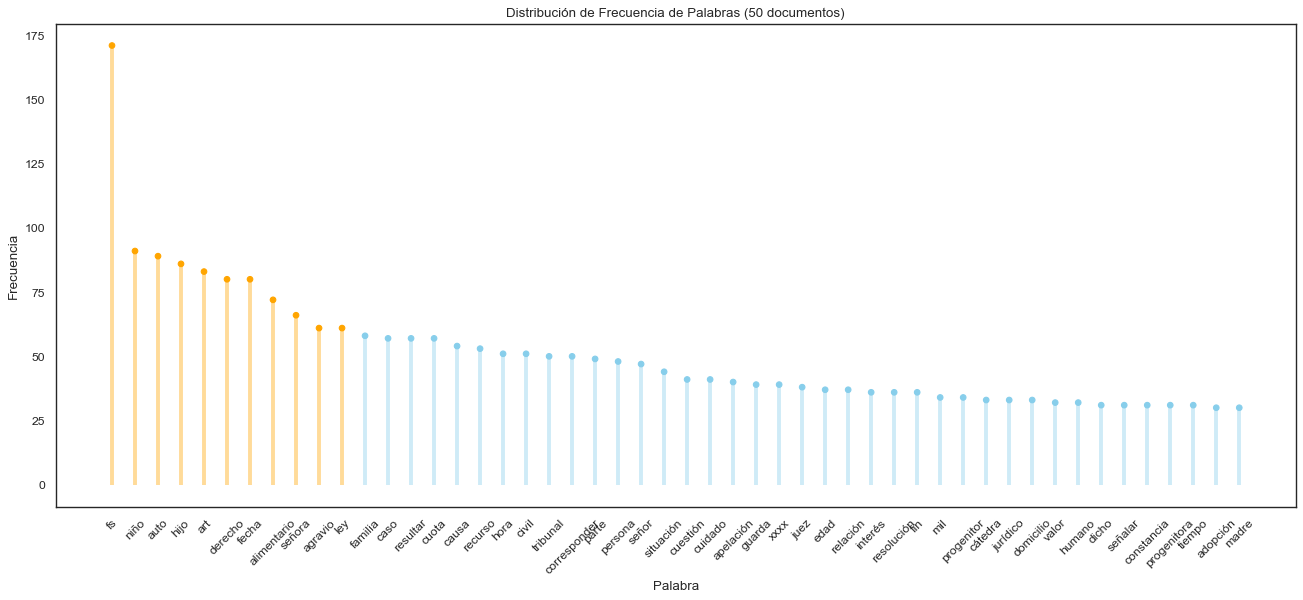

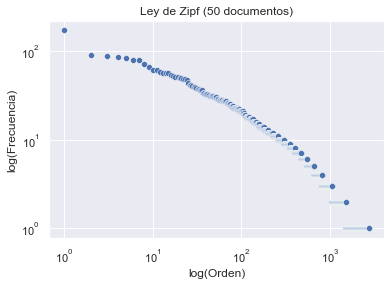

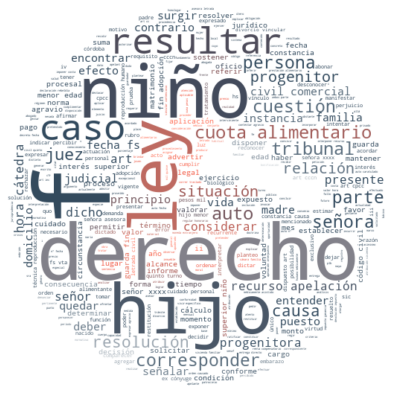

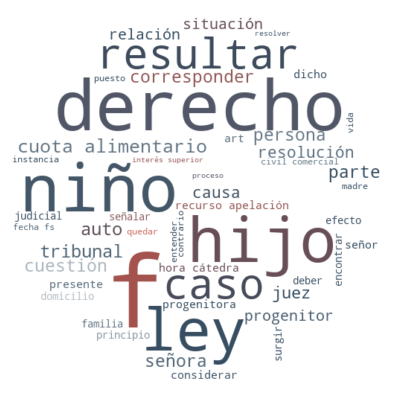


Análisis para todos documentos

Generamos Corpus de palabras y conteo de frecuencias
Algunas palabras: ['córdoba', 'veinticuatro', 'septiembre', 'mil', 'dieciocho']

Stemming vs Lematization
                word         lemma         stem
0            córdoba       córdoba       cordob
1       veinticuatro  veinticuatro  veinticuatr
2         septiembre    septiembre    septiembr
3                mil           mil          mil
4          dieciocho     dieciocho     diecioch
...              ...           ...          ...
524798         maría         maría          mar
524799    secretario    secretario    secretari
524800       general       general      general
524801    expediente    expediente    expedient
524802           nro           nro          nro

[524803 rows x 3 columns]

Ánalisis visual



C:\Users\azelaya004\AppData\Local\Temp\ipykernel_20516\137406334.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


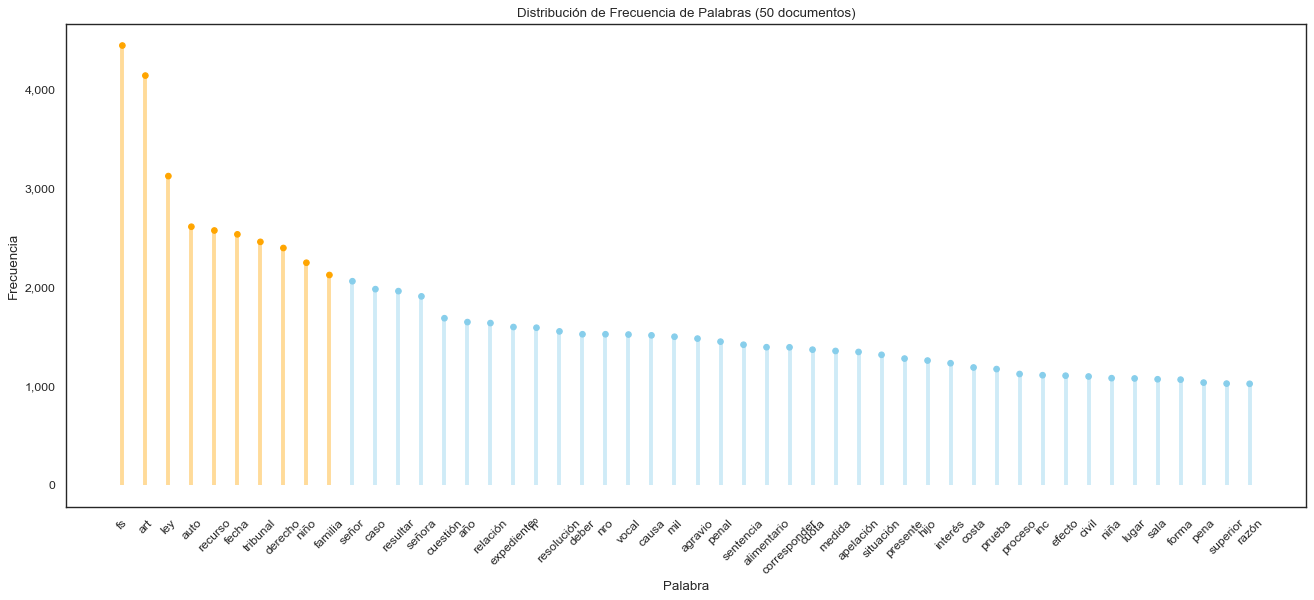

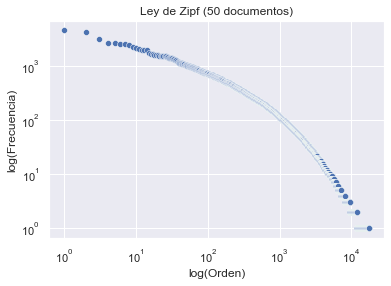

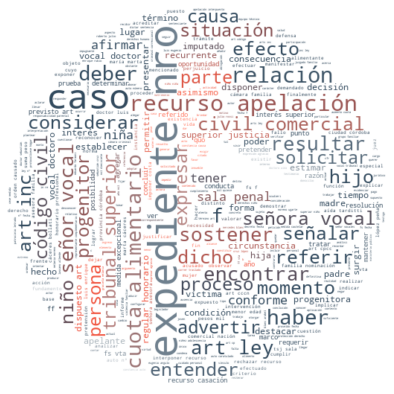

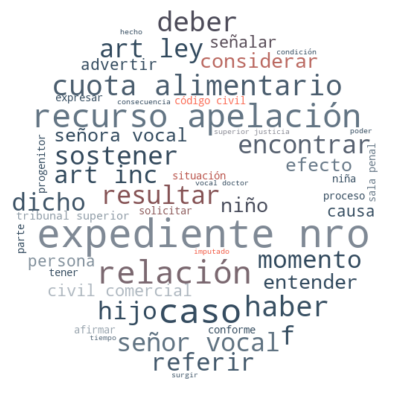

In [43]:
breakpoints = [5, None] # BREAKPOINT indica hasta cuantos documentos se van a tomar en el análisis (default=5)

for breakpoint in breakpoints:
    
    n_docs = breakpoint if breakpoint else 'todos'
    
    print(f"\nAnálisis para {n_docs} documentos\n")
    
    frecuencia_palabras_df, palabras = generar_corpus(filesDir, breakpoint)
    
    comparar_stemming_lematization(filesDir, breakpoint)
    
    print("\nÁnalisis visual\n")
    
    identifier = f"{n} documentos"
    plot_histogram(
        frecuencia_palabras_df,
        threshold=50,  # Nos quedamos con las 50 palabras más frecuentes (por legibilidad)
        y_low=None,
        description=identifier)
    
    show_zipf(frecuencia_palabras_df, description=identifier)
    
    img_name = "legal-icon-png"
    output_name = f"img/{img_name}_wordcloud_practico_2_{n_docs}.png"

    generar_wordcloud(img_name, STOPWORDS_ES, palabras, output_name)
    
    # n más frecuente
    n = 50
    output_name = f"img/{img_name}_wordcloud_practico_2_n{n}.png"

    generar_wordcloud(img_name, STOPWORDS_ES, palabras, output_name, max_words=n)
    
    

### Análisis por fueros



Stemming vs Lematization
                word         lemma         stem
0            córdoba       córdoba       cordob
1       veinticuatro  veinticuatro  veinticuatr
2         septiembre    septiembre    septiembr
3                mil           mil          mil
4          dieciocho     dieciocho     diecioch
...              ...           ...          ...
240100         bajen         bajar          baj
240101     presentes      presente      present
240102       juzgado       juzgado         juzg
240103        origen        origen         orig
240104       efectos        efecto        efect

[240105 rows x 3 columns]
Ánalisis visual



C:\Users\azelaya004\AppData\Local\Temp\ipykernel_20516\137406334.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


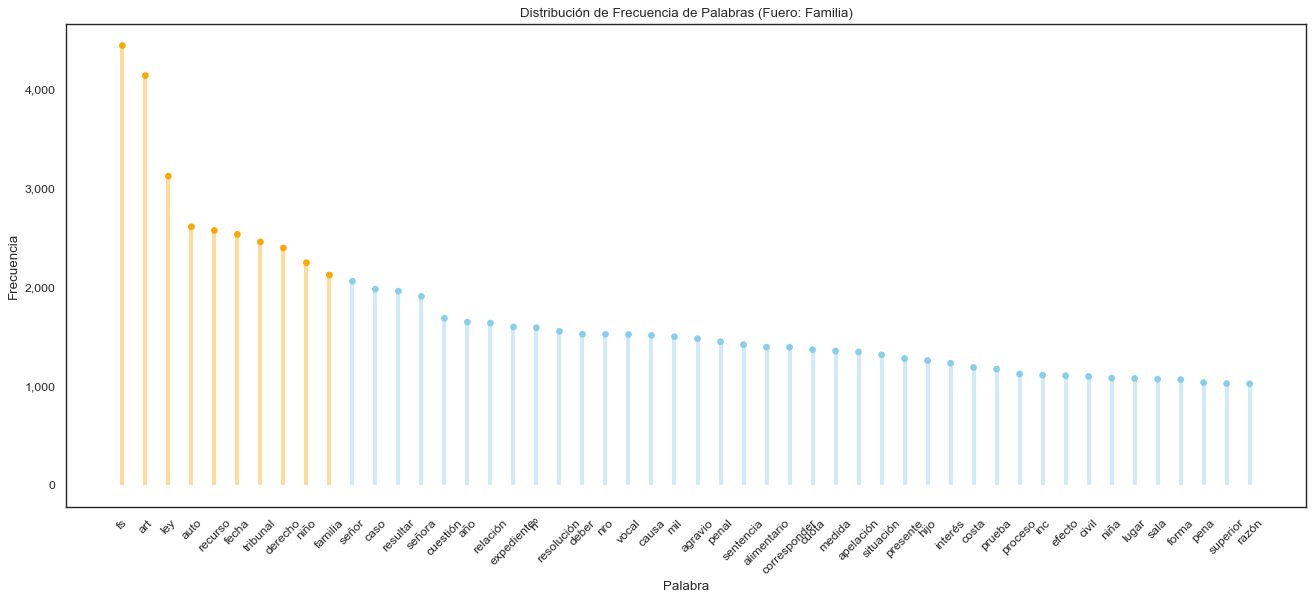

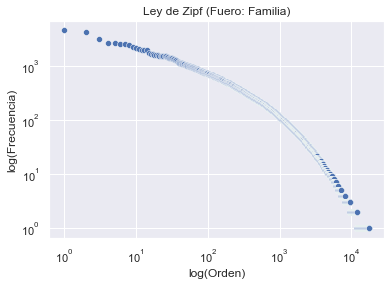

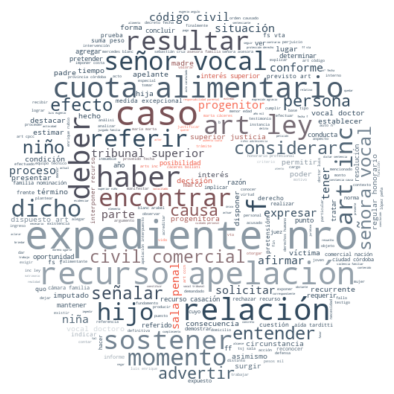

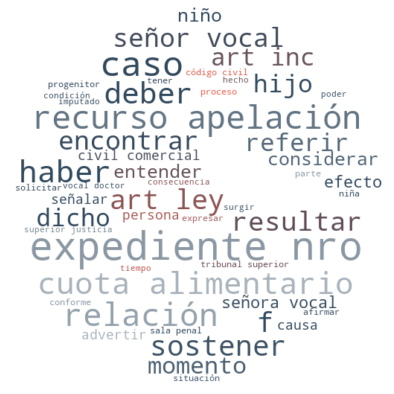


Stemming vs Lematization
             word       lemma       stem
0            sala        sala        sal
1         laboral     laboral    laboral
2        tribunal    tribunal   tribunal
3        superior    superior   superior
4       protocolo   protocolo   protocol
...           ...         ...        ...
30282     eduardo     eduardo     eduard
30283      javier      javier       javi
30284       fecha       fecha       fech
30285  expediente  expediente  expedient
30286         nro         nro        nro

[30287 rows x 3 columns]
Ánalisis visual



C:\Users\azelaya004\AppData\Local\Temp\ipykernel_20516\137406334.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


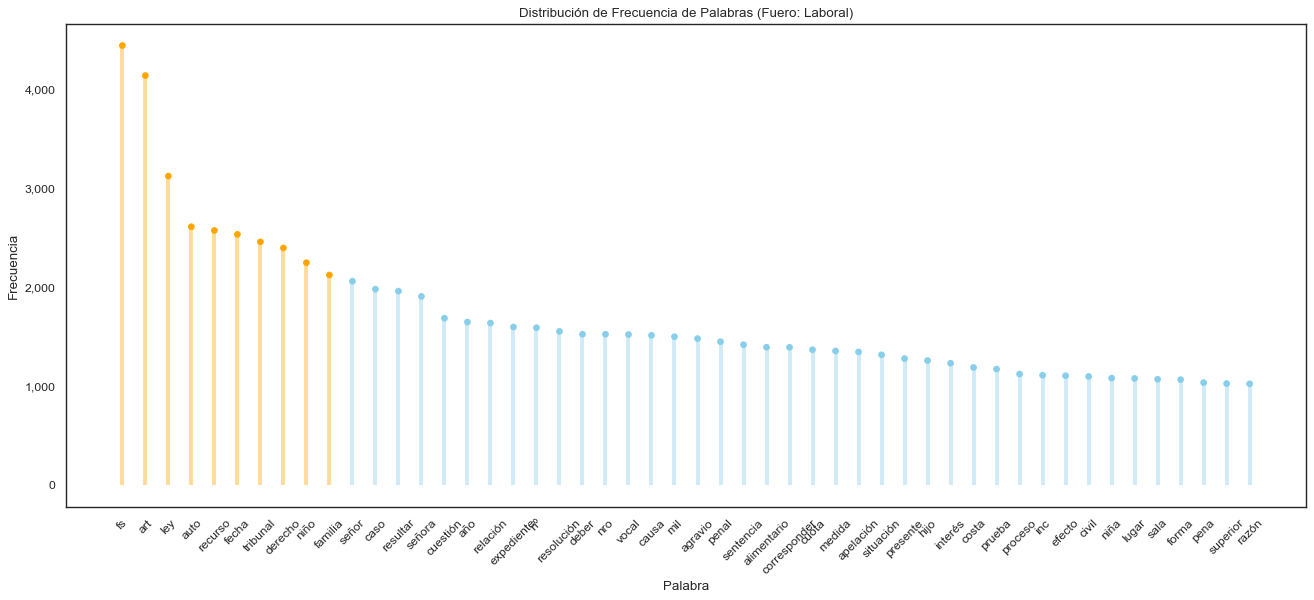

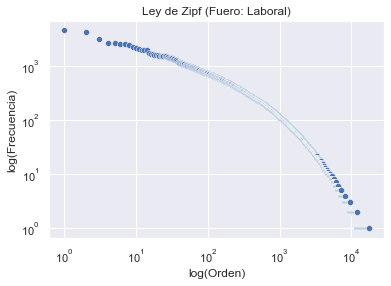

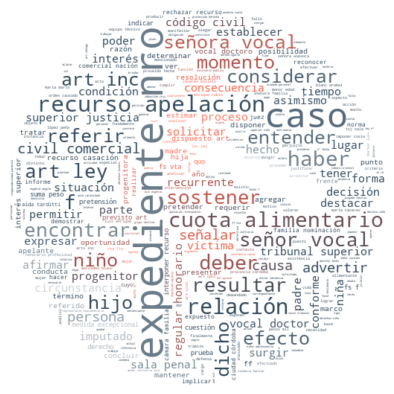

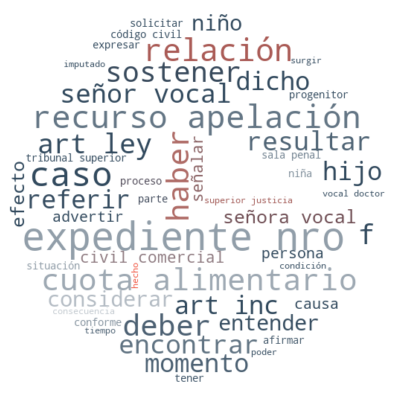


Stemming vs Lematization
          word    lemma    stem
0      materia  materia  materi
1        niñez    niñez   niñez
2      revista  revista  revist
3      familia  familia  famili
4        niñez    niñez   niñez
...        ...      ...     ...
77116   hágase    hágar     hag
77117     dese     dese     des
77118    copia    copia    copi
77119      fdo      fdo     fdo
77120   torres   torres    torr

[77121 rows x 3 columns]
Ánalisis visual



C:\Users\azelaya004\AppData\Local\Temp\ipykernel_20516\137406334.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


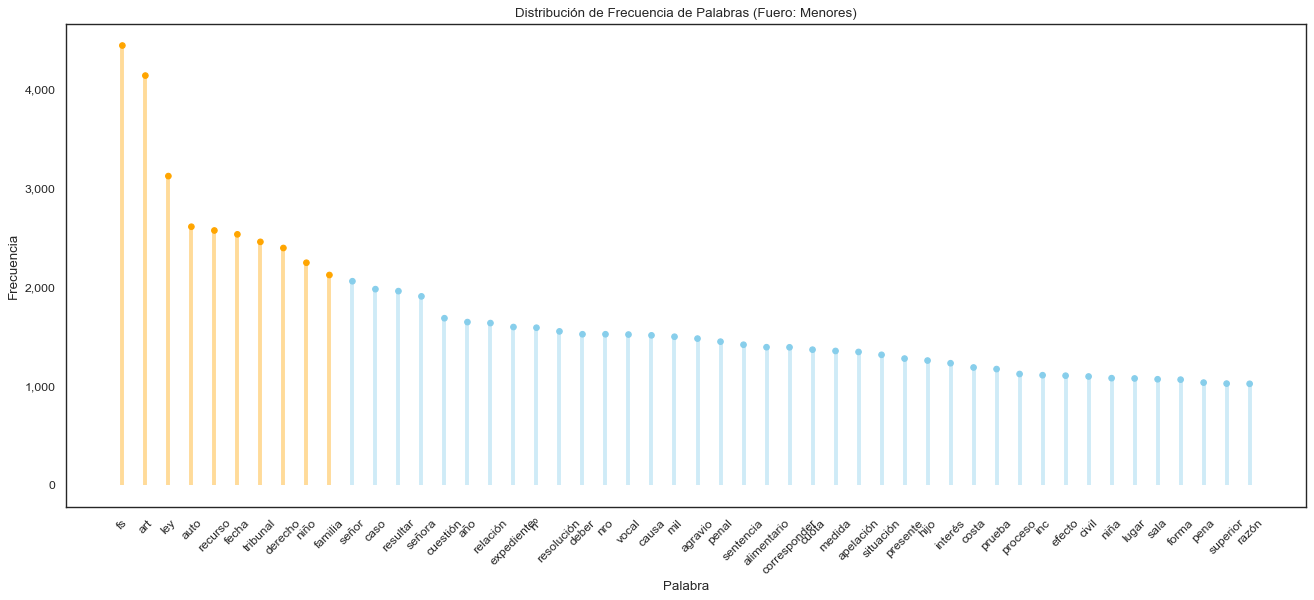

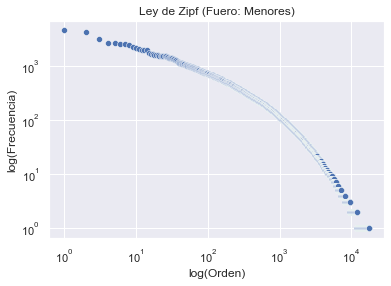

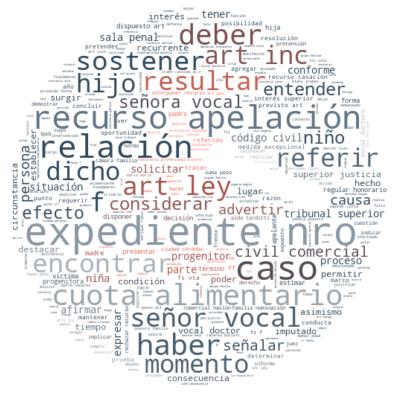

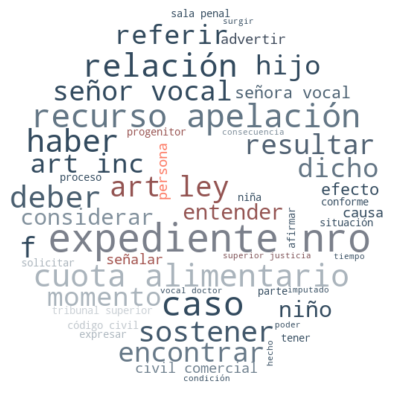


Stemming vs Lematization
              word       lemma       stem
0             sala        sala        sal
1            penal       penal      penal
2         tribunal    tribunal   tribunal
3         superior    superior   superior
4        protocolo   protocolo   protocol
...            ...         ...        ...
177285       maría       maría        mar
177286  secretario  secretario  secretari
177287     general     general    general
177288  expediente  expediente  expedient
177289         nro         nro        nro

[177290 rows x 3 columns]
Ánalisis visual



C:\Users\azelaya004\AppData\Local\Temp\ipykernel_20516\137406334.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


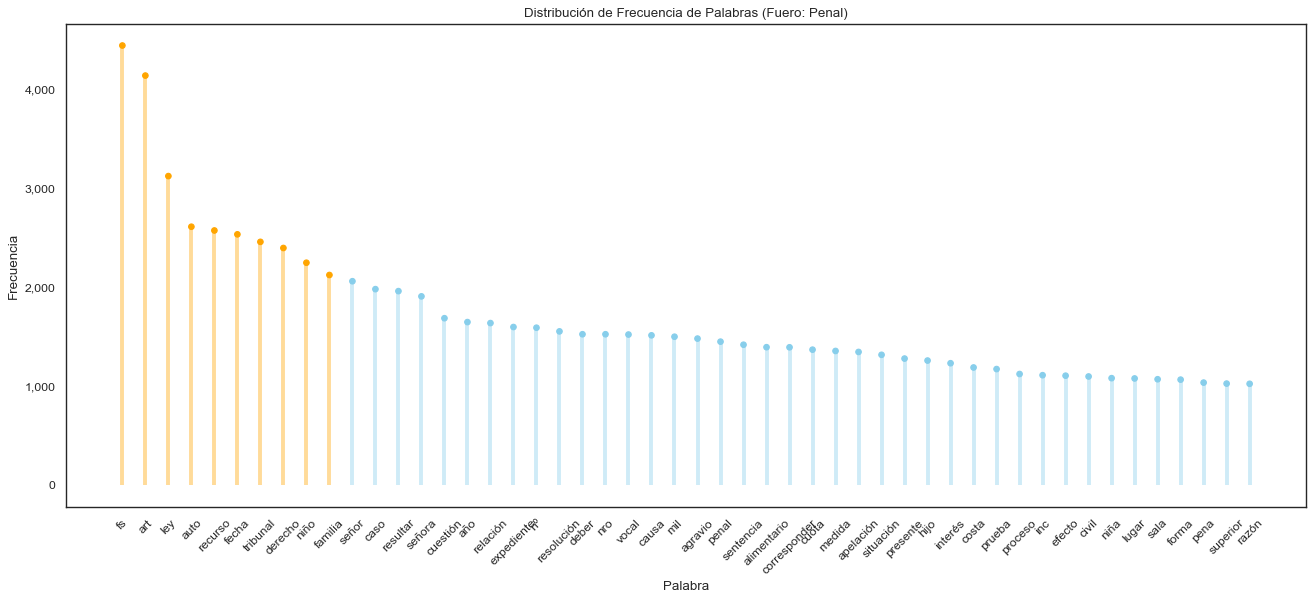

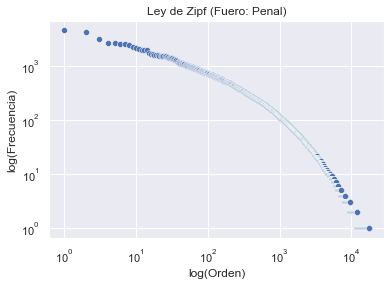

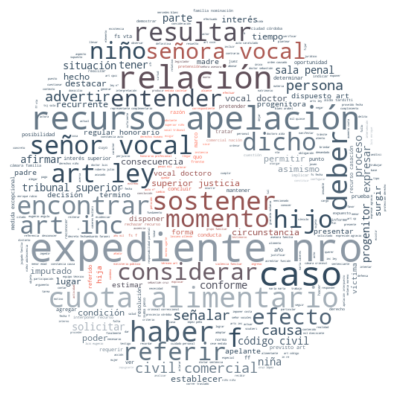

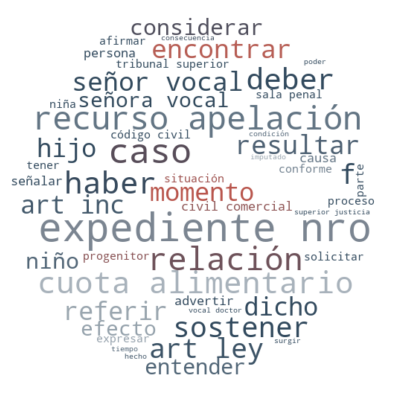

In [44]:
# Analizamos por fueros

fueros_lista = []


for fuero in ['FAMILIA', 'LABORAL', 'MENORES', 'PENAL']:
    filesDir = f"{CURR_DIR}\\Documentos\\{fuero}"
    identifier = f"Fuero: {fuero.title()}"
    palabras_fuero, corpus_dic_fuero = get_palabras(filesDir, fuero_name=fuero, breakpoint=BREAKPOINT)

    palabras_df = get_conteo_palabras(palabras_fuero)

    comparar_stemming_lematization(filesDir, BREAKPOINT)
    
    print("Ánalisis visual\n")
    
    #identifier = 'Analizamos frecuencia'
    plot_histogram(
        frecuencia_palabras_df,
        threshold=50,  # Nos quedamos con las 50 palabras más frecuentes (por legibilidad)
        y_low=None,
        description=identifier)
    
    show_zipf(frecuencia_palabras_df, description=identifier)
    
    img_name = "legal-icon-png"
    output_name = f"img/{img_name}_wordcloud_practico_2_{fuero}.png"

    generar_wordcloud(img_name, STOPWORDS_ES, palabras, output_name)
    
    # n más frecuente
    n = 50
    output_name = f"img/{img_name}_wordcloud_practico_2_n{n}.png"

    generar_wordcloud(img_name, STOPWORDS_ES, palabras, output_name, max_words=n)

## Opcionales

Investigar que es Segmentación y compararlo con Tokenización. Ejemplificar con un documento.
Investigar NER (Named Entity Recognition - Reconocimiento de Entitades Nombradas). Buscar las Entidadas Nombradas mas frecuentes en todo el corpus y por fuero.

### Segmentación vs Tokenización

https://tm-town-nlp-resources.s3.amazonaws.com/ch2.pdf

Segmentación es más abstracto >> es dividir el texto en partes: oraciones, párrafos, palabras, etc.

Tokenización es un caso específico de segmentación >> es la mínima unidad en la que podemos dividir el texto, e.g. palabras, puntuaciones, etc.


In [45]:
doc_path = f"{CURR_DIR}\Documentos\FAMILIA\A., A.-C.E.Divorcio vincular.doc.txt"

In [46]:
with open(doc_path, encoding='utf-8') as file:
    file_text = file.read()
    nlp_doc = nlp(file_text)
    i=0
    print("Ejemplo de tokenización vs segmentación por oración.\n")
    for token in nlp_doc:
        print(f"token: {token.text} - sentence: {token.sent}\n")
        i+=1
        if i > 5:
            break

Ejemplo de tokenización vs segmentación por oración.

token: AUTO - sentence: AUTO n.º 3.

token: n.º - sentence: AUTO n.º 3.

token: 3 - sentence: AUTO n.º 3.

token: . - sentence: AUTO n.º 3.

token: 
 - sentence: 
Córdoba, nueve de febrero de dos mil dieciocho.

token: Córdoba - sentence: 
Córdoba, nueve de febrero de dos mil dieciocho.



### Entidadas Nombradas mas frecuentes en todo el corpus

In [47]:
tokens, _ =  get_tokens(filesDir, breakpoint=BREAKPOINT)

tagged_entities = get_ner_from_tokens(tokens)

tagged_entities.groupby('entity').count().sort_values(by='token',ascending=False)

# ORG	Companies, agencies, institutions.
# MISC	Miscellanea
# LOC	Places
# PER	People, names

,token
entity,
,148982
PER,13485
MISC,7469
LOC,4051
ORG,3303


### NER: Named Entity Recognition

El proceso de categorizar palabras de acuerdo a ciertas reglas en entidades semánticas: organización, persona, lugar, etc.


In [ ]:
from spacy import displacy
nlp = spacy.load('es_core_news_lg')

displacy.serve(nlp_doc, style="ent")

C:\Users\azelaya004\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\displacy\__init__.py:103: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

